In [1]:
import re
import sys
import warnings
import graphviz 

import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category = SettingWithCopyWarning)

from ltrcart import LTRCart
from survival_data import SurvivalData

from sklearn import tree
from sklearn.preprocessing import OneHotEncoder

from sksurv.datasets import load_gbsg2
from sksurv.metrics import integrated_brier_score 
from sksurv.linear_model import CoxPHSurvivalAnalysis

from lifelines import CoxPHFitter
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

from scipy.stats import weibull_min

import os
os.environ["PYTHONWARNINGS"] = "ignore"

# Testing the LTRCart Tree class on some Real LTRC data

In [3]:
train = pd.read_csv("~/PycharmProjects/LTRCSurvivalTree/sample_data/creatinine_train.csv",index_col=0)
test = pd.read_csv("~/PycharmProjects/LTRCSurvivalTree/sample_data/creatinine_test.csv",index_col=0)

In [4]:
train.head()

,age,sex,sample.yr,kappa,lambda,FLC,creatinine,mgus,futime,death,chapter,End
1,97,F,1997,5.70,4.860,10,1.7,0,85,1,Circulatory,97.232877
2,92,F,2000,0.87,0.683,1,0.9,0,1281,1,Neoplasms,95.509589
3,94,F,1997,4.36,3.850,10,1.4,0,69,1,Circulatory,94.189041
4,92,F,1996,2.42,2.220,9,1.0,0,115,1,Circulatory,92.315068
5,93,F,1996,1.32,1.690,6,1.1,0,1039,1,Circulatory,95.846575


In [5]:
y_train = SurvivalData(train[['age','End','death']])
y_test = SurvivalData(test[['age','End','death']])

In [6]:
x_train = train.loc[:,['sex' , 'FLC' , 'creatinine']]
x_test = test.loc[:,['sex' , 'FLC' , 'creatinine']]

x_train = x_train.replace({'F':0,'M':1})
x_test = x_test.replace({'F':0,'M':1})

[Text(0.6666666666666666, 0.875, 'FLC <= 9.5\npoisson = 0.278\nsamples = 500\nvalue = 0.572'),
 Text(0.5, 0.625, 'creatinine <= 1.25\npoisson = 0.275\nsamples = 334\nvalue = 0.668'),
 Text(0.3333333333333333, 0.375, 'FLC <= 2.5\npoisson = 0.285\nsamples = 248\nvalue = 0.738'),
 Text(0.16666666666666666, 0.125, 'poisson = 0.319\nsamples = 28\nvalue = 1.097'),
 Text(0.5, 0.125, 'poisson = 0.269\nsamples = 220\nvalue = 0.692'),
 Text(0.6666666666666666, 0.375, 'poisson = 0.201\nsamples = 86\nvalue = 0.467'),
 Text(0.8333333333333334, 0.625, 'poisson = 0.231\nsamples = 166\nvalue = 0.379')]

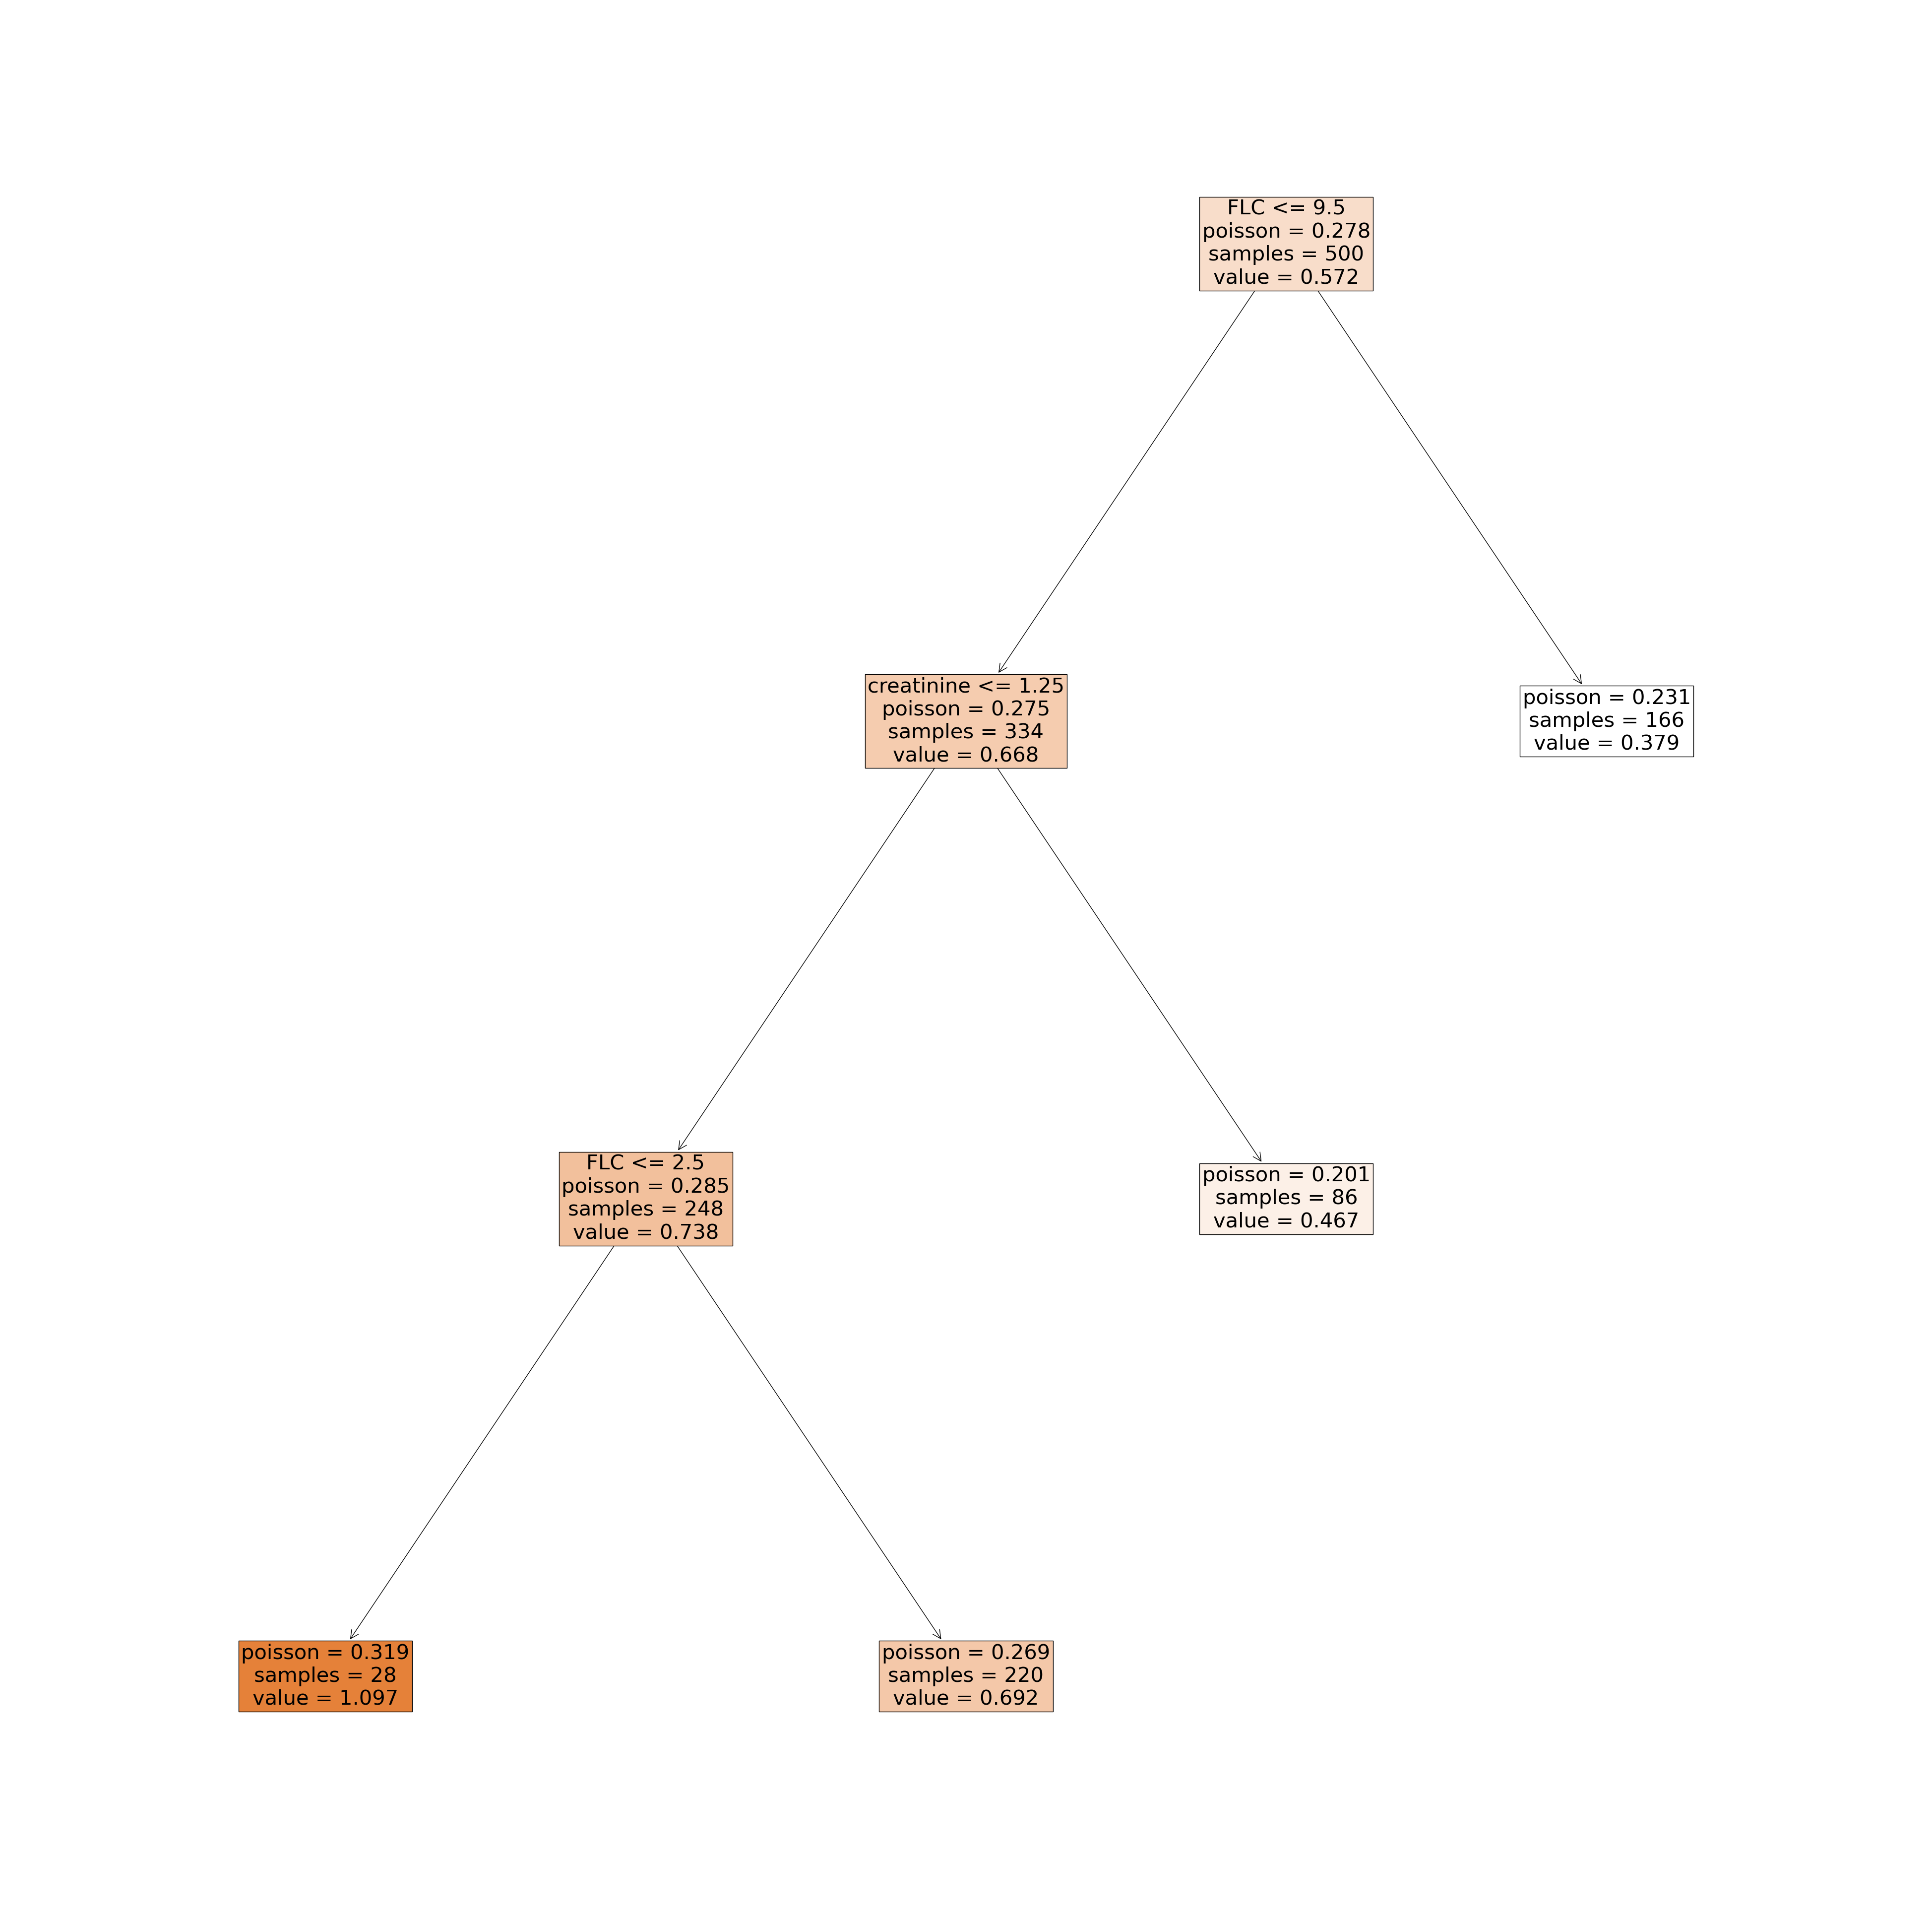

In [9]:
ltrc_art_obj =  LTRCart(y_train,x_train)
ltrc_cart_tree = ltrc_art_obj.ltrc_art_fit()
fig = plt.figure(figsize=(50,50))
tree.plot_tree(ltrc_cart_tree,fontsize=30,feature_names=x_train.columns,filled = True)

# Simulated data test

## Exponential simulated events

### simulated data function

In [2]:
class SimDataPrep():

    def __init__(self,left_t, heavy, n_obs,
                 proper_values = ['<= 2.5', '<= 1.5', '>  1.5', '>  2.5'],
                 proper_features = ['feature_0', 'feature_1', 'feature_1', 'feature_0', 'feature_2', 'feature_2']):
        """
        SimDataPrep is a class ment to easily apply the tree reconstruction simulation and generate simulated data.
        """
        self.proper_values = proper_values
        self.proper_features = proper_features
        self.left_t = left_t
        self.heavy = heavy
        self.n_obs = n_obs
        
    def create_sim_data_exp(self, dist_values=[1/0.1,1/0.23,1/0.4,1/0.9])->(pd.DataFrame, pd.DataFrame):
        """
        Creates exp simulated data
        """
        sim_data = self.sim_data()

        t_1=np.random.exponential(dist_values[0],5000)*((sim_data.x_1<=2) & (sim_data.x_2<=1))
        t_2=np.random.exponential(dist_values[1],5000)*((sim_data.x_1<=2) & (sim_data.x_2>1))
        t_3=np.random.exponential(dist_values[2],5000)*((sim_data.x_1>2) & (sim_data.x_3<=1))
        t_4=np.random.exponential(dist_values[3],5000)*((sim_data.x_1>2) & (sim_data.x_3>1))

        sim_data['t']= pd.DataFrame([t_1,t_2,t_3,t_4]).max()

        return self.censoring(sim_data)
    
    def create_sim_data_weibull(self, shape = 0.9, dist_values = [7,3,2.5,1])->(pd.DataFrame, pd.DataFrame):
        """
        Creates Weibull simulated data
        """
        sim_data = self.sim_data()

        t_1 = weibull_min.rvs(shape, 0, dist_values[0], size=5000) * ((sim_data.x_1<=2) & (sim_data.x_2<=1))
        t_2 = weibull_min.rvs(shape, 0, dist_values[1], size=5000) * ((sim_data.x_1<=2) & (sim_data.x_2>1))
        t_3 = weibull_min.rvs(shape, 0, dist_values[2], size=5000) * ((sim_data.x_1>2) & (sim_data.x_3<=1))
        t_4 = weibull_min.rvs(shape, 0, dist_values[3], size=5000) * ((sim_data.x_1>2) & (sim_data.x_3>1))

        sim_data['t'] = pd.DataFrame([t_1,t_2,t_3,t_4]).max()
        
        return self.censoring(sim_data)
    
    
    def create_sim_data_log_normal(self, mean = [2, 1.7, 1.3, 0.5], sigma = [0.3, 0.2, 0.3, 0.5])->(pd.DataFrame, pd.DataFrame):
        """
        Creates lognormal simulated data
        """
        sim_data = self.sim_data()

        t_1 = np.random.lognormal(mean[0], sigma[0], size=5000) * ((sim_data.x_1<=2) & (sim_data.x_2<=1))
        t_2 = np.random.lognormal(mean[1], sigma[1], size=5000) * ((sim_data.x_1<=2) & (sim_data.x_2>1))
        t_3 = np.random.lognormal(mean[2], sigma[2], size=5000) * ((sim_data.x_1>2) & (sim_data.x_3<=1))
        t_4 = np.random.lognormal(mean[3], sigma[3], size=5000) * ((sim_data.x_1>2) & (sim_data.x_3>1))

        sim_data['t'] = pd.DataFrame([t_1,t_2,t_3,t_4]).max()
        
        return self.censoring(sim_data)
    
    def create_sim_data_bathtub(self, a = [0.01, 0.05, 0.1, 0.7])->(pd.DataFrame, pd.DataFrame):
        """
        Creates bathtub simulated data
        """
        sim_data = self.sim_data()
        def bathtub_aux(a_i):
            t = np.random.rand(5000)
            bathtub_surv_function = (np.exp(-0.5*a_i*(t**2)))/((1+c*t)**(b/c))
            
        t_1 = bathtub_aux(a[0]) * ((sim_data.x_1<=2) & (sim_data.x_2<=1))
        t_2 = bathtub_aux(a[1]) * ((sim_data.x_1<=2) & (sim_data.x_2>1))
        t_3 = bathtub_aux(a[2]) * ((sim_data.x_1>2) & (sim_data.x_3<=1))
        t_4 = bathtub_aux(a[3]) * ((sim_data.x_1>2) & (sim_data.x_3>1))

        sim_data.loc[:, 't'] = pd.DataFrame([t_1,t_2,t_3,t_4]).max()
        
        return self.censoring(sim_data)
    
    
    def tree_reconstruction(self, y_s, x_s):
        """
        The function recives y and x to fit to the ltrc_cart trees,
        It is then compares the achived tree nodes and splitting values to the currect tree.
        returns true if the tree has the same structure and False otherwise.
        """
        surv_data = SurvivalData(y_s)
        ltrc_cart_tree = LTRCart(surv_data,x_s, control = {"max_depth":30, "min_samples_split":20, "min_samples_leaf":round(20/3)})
        ltrc_cart_tree = ltrc_cart_tree.fit()
        tree_as_text = tree.export_text(ltrc_cart_tree,max_depth=1)
        tree_features = re.findall('feature_*\\S',tree_as_text)
        tree_values = re.findall('<= [0-9].[0-9]|>  [0-9].[0-9]',tree_as_text)[0:4]
        if ((tree_features == self.proper_features) & (tree_values == self.proper_values)):
            return True
        return False
    
    def trs_exp(self):
        try:
            y_s,x_s = self.create_sim_data_exp()
            return self.tree_reconstruction(y_s, x_s)
        except:
            return False
    
    def trs_weibull_i(self):
        try:
            y_s,x_s = self.create_sim_data_weibull()
            return self.tree_reconstruction(y_s, x_s)
        except:
            return False
        
    def trs_weibull_d(self):
        try:
            y_s,x_s = self.create_sim_data_weibull(shape = 3, dist_values = [2.0, 4.3, 6.2, 10.0])
            return self.tree_reconstruction(y_s, x_s)
        except:
            return False
    
    
    def trs_log_normal(self):
        try:
            y_s,x_s = self.create_sim_data_log_normal()
            return self.tree_reconstruction(y_s, x_s)
        except:
            return False
        
    def censoring(self, sim_data) -> pd.DataFrame:
        """
        adds the correct censoring to the simulated data.
        """
        
        sim_data = sim_data.loc[sim_data['t'] >= sim_data['left_t']]
        prop_cens = 0
        data_length = sim_data.shape[0]
        c = 16
        sim_data['c'] = sim_data.left_t + pd.Series(np.random.exponential(scale = c,size = data_length))
        min_cens = 0.5 if self.heavy else 0.2
        while prop_cens <= min_cens:
            sim_data.loc[:,'c'] = sim_data.left_t + pd.Series(np.random.exponential(scale = c,size = data_length))
            prop_cens = ((sim_data['c'] < sim_data['t']).sum() / data_length)
            c -= 0.1
        sim_data['event'] = (sim_data.c >= sim_data.t).astype(int)
        sim_data['t'] = sim_data[['t','c']].min(axis = 1)
        return (sim_data[['left_t', 't', 'event']].iloc[:self.n_obs].copy(),
                sim_data[['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6']].iloc[:self.n_obs].copy())
    
    
    def sim_data(self) -> pd.DataFrame:
        """
        Creates the simulated data according to the True tree.
        """
        x_1, x_4 = np.random.randint(1,6,5000), np.random.randint(1,6,5000)
        x_2, x_5 = np.random.randint(1,3,5000), np.random.randint(1,3,5000)
        x_3, x_6 = np.random.rand(5000) * 2, np.random.rand(5000) * 2
        sim_data = pd.DataFrame({'x_1':x_1,'x_2':x_2,'x_3':x_3,'x_4':x_4,'x_5':x_5,'x_6':x_6})

        sim_data['left_t'] = np.random.rand(5000) * self.left_t
        return sim_data

### The actual tree constraction

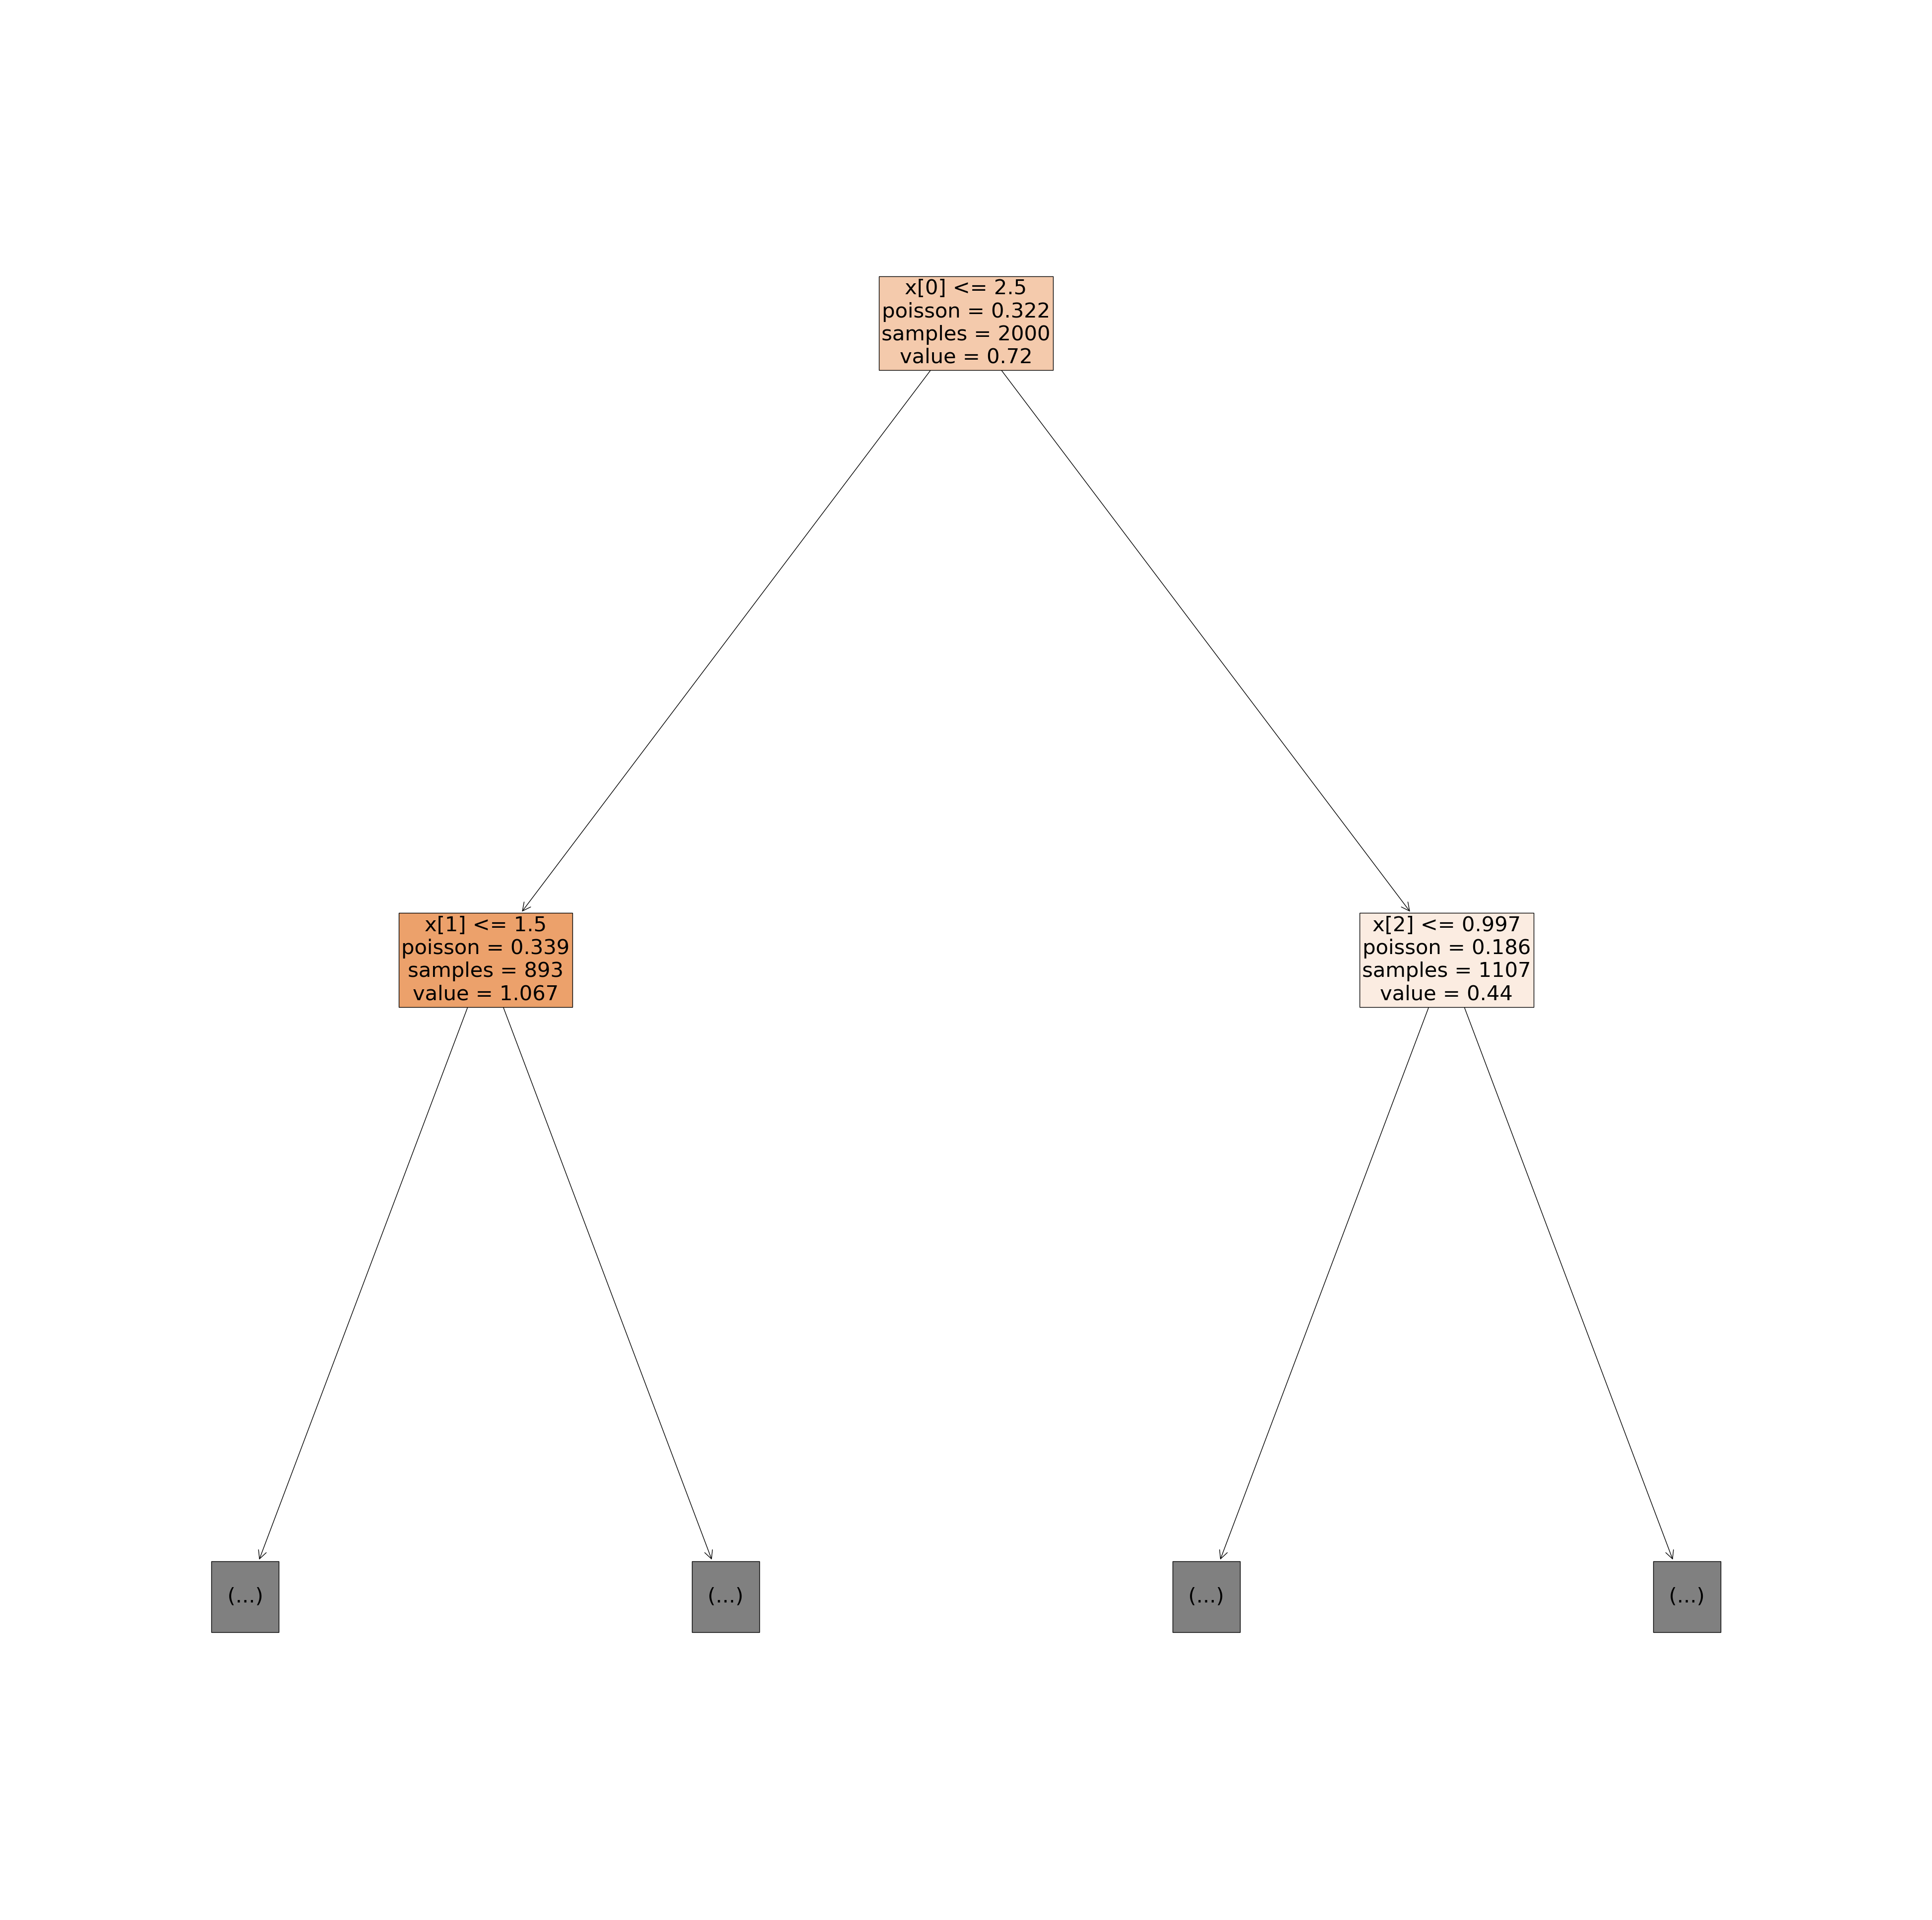

In [241]:
sdp = SimDataPrep(heavy=False, n_obs=2000, lt=1)
y_light_s,x_light_s = sdp.create_sim_data_exp()
surv_data = SurvivalData(y_light_s)
ltrc_art_tree =LTRCart(surv_data,x_light_s, control = {"max_depth":30, "min_samples_split":20, "min_samples_leaf":round(20/3)})
ltrc_art_tree = ltrc_art_tree.ltrc_art_fit()
fig = plt.figure(figsize=(50,50))
plot_tree = tree.plot_tree(ltrc_art_tree,fontsize=30,filled = True,max_depth=1)

### Simulation for all different exp parameters 
- Heavy/Light censoring
- Sample size for training
- Left Truncation distribution ($U[0,1], U[0,2], U[0,3]$)\
Each config was tested for 1000 times and the Accuracy was saved in the currrect table.
Running this simulation involves creating simulated data and fitting trees 72,000 times and it takes around 3.5 hours on a strong personal computer thanks to Parallel computing(4 performance cores on an M2 chip).\
**Note:** This simulation might not be exactly equal to the simulations which was on the original paper "Survival trees for left-truncated and right-censored data, with application to time-varying covariate data" of Wei Fu Jeffrey S. Simonof since the R packages differ in many ways from the python packages, mostly with initial values and some differences in statistical methods. In addition, it is hard to say what does tree-reconstruction means in the paper, should we get the exact same trees with the exact same values? or should we just get the same explaining variable in a particular order? We assumed in our test that the first 2 levels of the trees must be almost identical, meaning, the splitting variables are exactly the same in the exact same position as the original tree, we further assumed that the splitting value of the binary and intiger variables must be equal exactly to those of the original tree, but that the continuous variable splitting value might differ, this is due to the fact that its continuous and might be slightly different for different simulations.
We also didn't grant any importance to the tree depth but only to its first 2 levels, this is due to the fact that if the tree managed to reconstruct the first two levels then it succesfully managed to split the data into 4 different groups, the subgroups that came after could be good as random.

In [187]:
results_df = pd.DataFrame({'heavy':[True,True,True,False,False,False]*3,
                               'n_obs':[100,300,500,100,300,500]*3, 
                               'left_t':[1,1,1,2,2,2,3,3,3]*2, 'res':[0]*18})
results_df = results_df.set_index(['heavy','n_obs','left_t'])
results_df = results_df.sort_index()
results_df_exp = results_df.copy()
results_df_exp['type'] = 'exp'

results_df_weibull_i = results_df.copy()
results_df_weibull_i['type'] = 'Weibull-I'

results_df_weibull_d = results_df.copy()
results_df_weibull_d['type'] = 'Weibull-D'

results_df_log_normal = results_df.copy()
results_df_log_normal['type'] = 'log normal'
counter = 0
for heavy_param in (True,False):
    for n_obs_param in (100,300, 500):
        for lt_param in (1, 2, 3):
            warnings.simplefilter(action="ignore", category = SettingWithCopyWarning)

            sdp = SimDataPrep(heavy = heavy_param, n_obs = n_obs_param, left_t = lt_param)
            
            results_exp = np.mean(Parallel(n_jobs=4)(delayed(sdp.trs_exp)() for i in range(1000)))
            results_df_exp.loc[(heavy_param,n_obs_param,lt_param), 'res'] = results_exp
            
            results_weibull_i = np.mean(Parallel(n_jobs=4)(delayed(sdp.trs_weibull_i)() for i in range(1000)))
            results_df_weibull_i.loc[(heavy_param, n_obs_param, lt_param), 'res'] = results_weibull_i

            results_weibull_d = np.mean(Parallel(n_jobs=4)(delayed(sdp.trs_weibull_d)() for i in range(1000)))
            results_df_weibull_d.loc[(heavy_param, n_obs_param, lt_param), 'res'] = results_weibull_d
            
            log_normal_res = np.mean(Parallel(n_jobs=4)(delayed(sdp.trs_log_normal)() for i in range(1000)))
            results_df_log_normal.loc[(heavy_param, n_obs_param, lt_param), 'res'] = log_normal_res
            
main_res_df = pd.concat([results_df_exp, results_df_weibull_i, results_df_weibull_d, results_df_log_normal])
main_res_df = main_res_df.set_index('type',append=True).unstack().droplevel(0,axis=1)
main_res_df.to_csv('table_1.csv')

### Simulation Results

In [188]:
main_res_df*100

type                Weibull-D  Weibull-I   exp  log normal
heavy n_obs left_t                                        
False 100   1            65.8        3.1  10.2        32.7
            2            60.3        2.7   8.0        38.7
            3            52.5        2.3   6.7        35.4
      300   1            73.2       25.2  35.9        71.4
            2            69.4       21.6  34.5        74.5
            3            68.2       19.9  28.9        72.7
      500   1            75.5       50.7  63.2        81.1
            2            73.3       55.3  58.6        82.6
            3            69.5       48.8  53.3        82.0
True  100   1            21.6        0.1   0.5         5.6
            2            20.0        0.1   0.1         5.9
            3            12.1        0.0   0.1         3.4
      300   1            51.5        0.5   1.4        11.0
            2            49.8        0.0   0.3        10.0
            3            44.1        0.2   0.0         9.4
      500   1            63.7        1.5   3.7        19.7
            2            67.1        0.1   0.5        16.6
            3            61.3        0.0   0.2        15.5

# Brier score
There was an attempt to replicate the IBS simulation, However we came into a conclusion that this is an overkill for the project(in terms of effort invested in return of results). Since we managed to replicate the trees quite well we assume that the brier score is quite similar as well, altough obviously farther research is required.

In [74]:
# sdp = SimDataPrep(heavy=False , n_obs=200, left_t=1)
# sim_data_exp = sdp.create_sim_data_exp()

# y = sim_data_exp[0]
# x = sim_data_exp[1]
# s_y = SurvivalData(y)

# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return array[idx]

# new_y = y.loc[y.event==1][['event','t']].to_numpy()
# #List of tuples
# aux = [(e1,e2) for e1,e2 in new_y]
# #Structured array
# new_y= np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

# ltrc_tree = LTRCart(s_y,x)
# ltrc_tree.fit()
# predictions = ltrc_tree.predict(x)
# km_curves = predictions['km_curves']
# survs = pd.Series(km_curves).map(lambda x: x.survival_function_)
# times = s_y.survival_data.loc[((s_y.survival_data.event == 1)
#                                & (s_y.survival_data.time2<y.t.max())
#                                & (s_y.survival_data.time2>y.t.min())), 'time2']

# preds = []

# for surv in survs:
#     preds_surv = []
#     for t in times:
#         indx = find_nearest(np.array(surv.index),t)
#         preds_surv.append(surv.loc[indx].values)
#     preds.append(preds_surv)
# preds = np.asarray(preds)
# # preds = np.asarray([[surv.loc[t] for t in times[times.isin(surv.index)]] for surv in survs])
# score = integrated_brier_score(new_y, new_y, preds[0], times)
# print(score)

In [ ]:
# def cox_ibs(y,X):

#     # y, X = y.iloc[:300], X.iloc[:300]
#     new_y = y[['event','t']].to_numpy()
#     #List of tuples
#     aux = [(e1,e2) for e1,e2 in new_y]

#     #Structured array
#     new_y= np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

#     est_5 = CoxPHSurvivalAnalysis(ties="efron").fit(X, new_y)
#     survs_5 = est.predict_survival_function(X)
#     est_6 = CoxPHFitter(penalizer=0).fit(df=y, duration_col='t', event_col='event', entry_col='lt')
#     survs_6 = est_6.predict_survival_function(X)
#     times = y.loc[((y.event==1) & (y.t<y.t.max())),'t']
    
#     preds_5 = np.asarray([[fn(t) for t in times] for fn in survs_5])
#     preds_6 = np.asarray([[fn[t] for t in times] for fn in survs_6])

#     score_5 = integrated_brier_score(new_y, new_y, pred_5, times)
#     score_6 = integrated_brier_score(new_y, new_y, preds_6, times)
#     return score_5,score_6

# Example of getting test km curves

### Fitting the data

In [75]:
sim_data_exp = sdp.create_sim_data_exp()

y = sim_data_exp[0]
x = sim_data_exp[1]
s_y = SurvivalData(y)

ltrc_tree = LTRCart(s_y,x)
ltrc_tree.fit()

### Testing the data

In [76]:
sim_data_exp_test = sdp.create_sim_data_exp()
x_test = sim_data_exp_test[1]
res = ltrc_tree.predict(x_test)
km = res['km_curves']

### Example survival function curve for obs 0

<AxesSubplot:xlabel='timeline'>

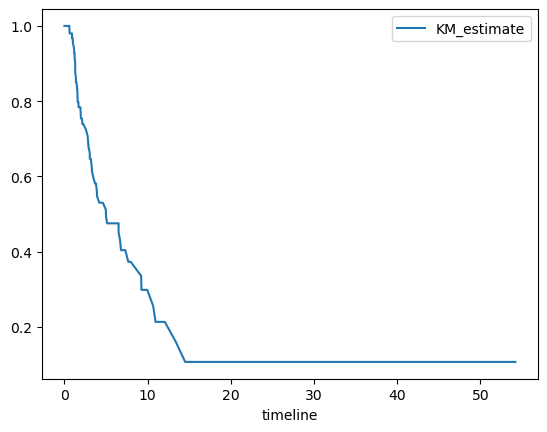

In [80]:
km[0].survival_function_.plot()